In [37]:
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Gather Data

In [2]:
def get_confidence(model, conf):
    file_path = f"/Users/ivan/Documents/uni-projects/LLM-Calibration-Study/results/mmlu_pro_{model}_{conf}_shared_sampling_None.html"
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r"Extracted Answer Confidence:\s([0-1\]*\.?[0-9]+)")

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return np.array(matches, dtype=float)

def get_accuracy(model, conf):
    file_path = f"/Users/ivan/Documents/uni-projects/LLM-Calibration-Study/results/mmlu_pro_{model}_{conf}_shared_sampling_None.html"
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r"Score:\s([0-1]*\.?[0-9]+)")

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return np.array(matches, dtype=float)

def get_subject(model, conf):
    file_path = f"/Users/ivan/Documents/uni-projects/LLM-Calibration-Study/results/mmlu_pro_{model}_{conf}_shared_sampling_None.html"
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r'\nSubject:\s(.+)\n')

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return (matches)

In [3]:
mini_verbal_num_results_df = pd.DataFrame({"category": get_subject("gpt-4.1-mini", "verbal_numerical"), "accuracy": get_accuracy("gpt-4.1-mini", "verbal_numerical"), "confidence": get_confidence("gpt-4.1-mini", "verbal_numerical")})
mini_logit_results_df = pd.DataFrame({"category": get_subject("gpt-4.1-mini", "logit_perplexity"), "accuracy": get_accuracy("gpt-4.1-mini", "logit_perplexity"), "confidence": get_confidence("gpt-4.1-nano", "logit_perplexity")})

In [4]:
nano_verbal_num_results_df = pd.DataFrame({"category": get_subject("gpt-4.1-nano", "verbal_numerical"), "accuracy": get_accuracy("gpt-4.1-nano", "verbal_numerical"), "confidence": get_confidence("gpt-4.1-nano", "verbal_numerical")})
nano_logit_results_df = pd.DataFrame({"category": get_subject("gpt-4.1-nano", "logit_perplexity"), "accuracy": get_accuracy("gpt-4.1-nano", "logit_perplexity"), "confidence": get_confidence("gpt-4.1-nano", "logit_perplexity")})

In [5]:
def calculate_ece(confidences, accuracies, n_bins=10) -> float:
    """
    Calculate the expected calibration error (ECE) given a list of confidence scores (0-1) and accuracy scores (0 or 1).
    """
    confidences = torch.tensor(confidences)
    accuracies = torch.tensor(accuracies)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

def stratified_sample(df, sample_frac=0.2):
    # Step 1: Stratified sampling
    stratified_df, _ = train_test_split(
        df, 
        train_size=sample_frac, 
        stratify=df['category']
    )
    return stratified_df

In [27]:
def get_ece(results_df):
    category_sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ece = {size : [] for size in category_sample_sizes}
    repeat = 50
    for size in category_sample_sizes:
        for _ in range(repeat):
            ss = stratified_sample(results_df, size)
            acc = ss["accuracy"].tolist()
            conf = ss["confidence"].tolist()
            ece[size].append(calculate_ece(conf, acc))
    return ece

# Results

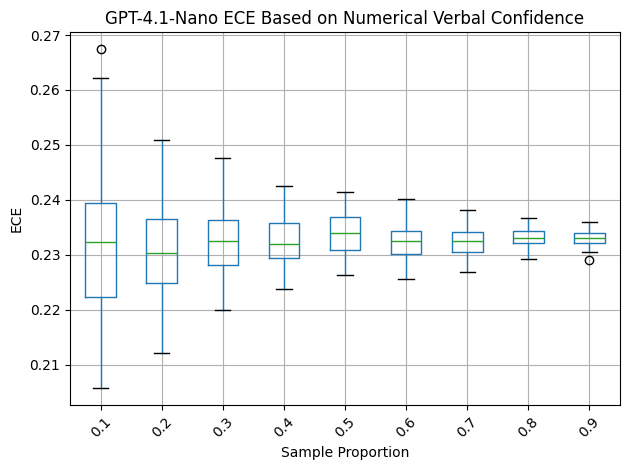

In [33]:
fig = pd.DataFrame(get_ece(nano_verbal_num_results_df)).boxplot()
plt.title("GPT-4.1-Nano ECE Based on Numerical Verbal Confidence")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("ECE")
plt.tight_layout()
plt.show()

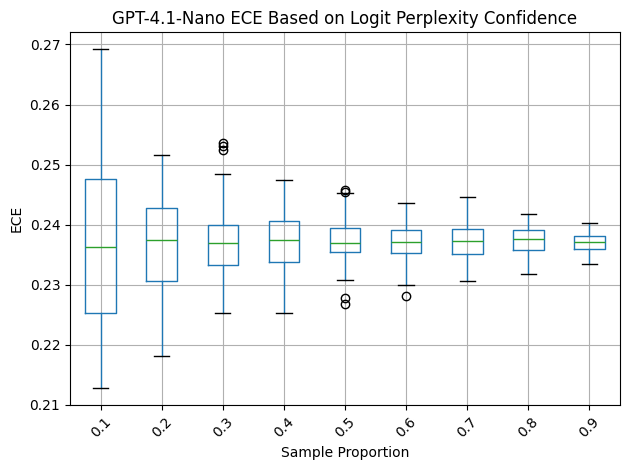

In [34]:
fig = pd.DataFrame(get_ece(nano_logit_results_df)).boxplot()
plt.title("GPT-4.1-Nano ECE Based on Logit Perplexity Confidence")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("ECE")
plt.tight_layout()
plt.show()

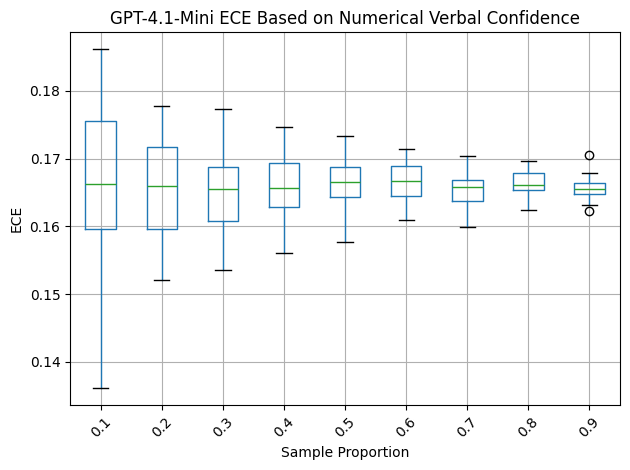

In [39]:
fig = pd.DataFrame(get_ece(mini_verbal_num_results_df)).boxplot()
plt.title("GPT-4.1-Mini ECE Based on Numerical Verbal Confidence")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("ECE")
plt.tight_layout()
plt.show()

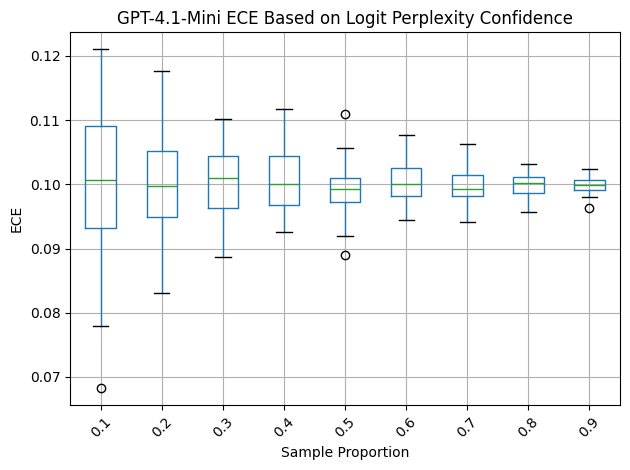

In [36]:
fig = pd.DataFrame(get_ece(mini_logit_results_df)).boxplot()
plt.title("GPT-4.1-Mini ECE Based on Logit Perplexity Confidence")
plt.xticks(rotation=45)
plt.xlabel("Sample Proportion")
plt.ylabel("ECE")
plt.tight_layout()
plt.show()